In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
np.random.seed(42)
num_classes = 46
blank_label = 0

SEGMENT_WIDTH = 8
SEGMENT_HEIGHT = 65
SEGMENT_CHANNELS = 1

batch_size = 4
batch_size_val = 1

sequence_lengths = np.array([18 for k in range(batch_size)] + [20 for k in range(batch_size)])
label_lengths = np.array([9 for k in range(batch_size)] + [10 for k in range(batch_size)])

sequence_lengths_val = np.array([18 for k in range(batch_size)] + [20 for k in range(batch_size)])
label_lengths_val = np.array([9 for k in range(batch_size)] + [10 for k in range(batch_size)])

# Simulate batches of sequential data: (N, T, W, H, C)
X_batches = [np.random.uniform(0,1, size=((batch_size, k, 8, 65, 1))) for k in [18, 20]]

# Simulate batches of labels: (N, T)
y_batches = [np.random.randint(num_classes-1, size=(batch_size, k)) for k in [9, 10]]

X_batches_val = [np.random.uniform(0,1, size=((batch_size_val, k, 8, 65, 1))) for k in [18, 20]]
y_batches_val = [np.random.randint(num_classes-1, size=(batch_size_val, k)) for k in [9, 10]]
                                   

# Tensorflow testing

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, TimeDistributed, Lambda, LSTM
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

In [4]:
# Baseline model
def get_segment_tensors():
  segment_input = tf.keras.Input(shape=(SEGMENT_WIDTH, SEGMENT_HEIGHT, SEGMENT_CHANNELS))
  x = tf.keras.layers.Masking(mask_value=-1.0)(segment_input)
  x = Flatten()(segment_input)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation='relu')(x)
  segment_output = Flatten()(x)
  return TimeDistributed(tf.keras.Model(segment_input, segment_output))

# Model for data containing the sequence of segments
input_segments_data = tf.keras.Input(name='input_segments_data',
                                     shape=(None, SEGMENT_WIDTH, SEGMENT_HEIGHT, SEGMENT_CHANNELS),
                                     dtype='float32')

input_label_data = tf.keras.Input(name='input_label_data', shape=(None,), dtype='int64')
input_segment_lengths = tf.keras.Input(name='input_segment_lengths', shape=[1], dtype='int64')
input_label_lengths = tf.keras.Input(name='input_label_lengths', shape=[1], dtype='int64')

x = get_segment_tensors()(input_segments_data)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x) 
x = Dropout(0.25)(x)
predicted_labels = Dense(num_classes, activation='softmax', name='predicted_labels')(x)

# Actual CTC loss calculation happens here
def ctc_lambda(args):
  y_true, y_pred, segment_lengths, label_lengths = args
  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, segment_lengths, label_lengths)
  return loss

loss_out = Lambda(ctc_lambda,
                  name='ctc',
                  output_shape=(1,))([input_label_data, predicted_labels, input_segment_lengths, input_label_lengths])

baseline_model = tf.keras.Model(inputs=[input_segments_data, input_label_data, input_segment_lengths, input_label_lengths],
                                outputs=[loss_out, predicted_labels], name='Baseline model')


baseline_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                       optimizer=tf.keras.optimizers.Adam())

baseline_model.summary()

W0625 13:57:53.849941 139826163263296 deprecation.py:323] From /home/dnagy/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0625 13:57:53.921238 139826163263296 training_utils.py:1237] Output predicted_labels missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to predicted_labels.


Model: "Baseline model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_segments_data (InputLayer [(None, None, 8, 65, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 128)    182784      input_segments_data[0][0]        
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 16)     9280        time_distributed[0][0]           
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 16)     2112        lstm[0][0]                       
_____________________________________________________________________________________

In [5]:
# Use any dummy y data, because the loss happens elsewhere
batch_index = 0
H = baseline_model.fit([X_batches[batch_index], y_batches[batch_index], 
                        np.array(sequence_lengths[batch_size*batch_index:batch_size*(batch_index+1)]),
                        np.array(label_lengths[batch_size*batch_index:batch_size*(batch_index+1)])],
                       [0 for k in range(batch_size)],
                       validation_data=([X_batches_val[batch_index], y_batches_val[batch_index],
                                         np.array(sequence_lengths_val[batch_size_val*batch_index:batch_size_val*(batch_index+1)]),
                                         np.array(label_lengths[batch_size_val*batch_index:batch_size_val*(batch_index+1)])],
                                        [0 for k in range(batch_size_val)]),
                       epochs=600, verbose=0)

<Figure size 432x288 with 0 Axes>

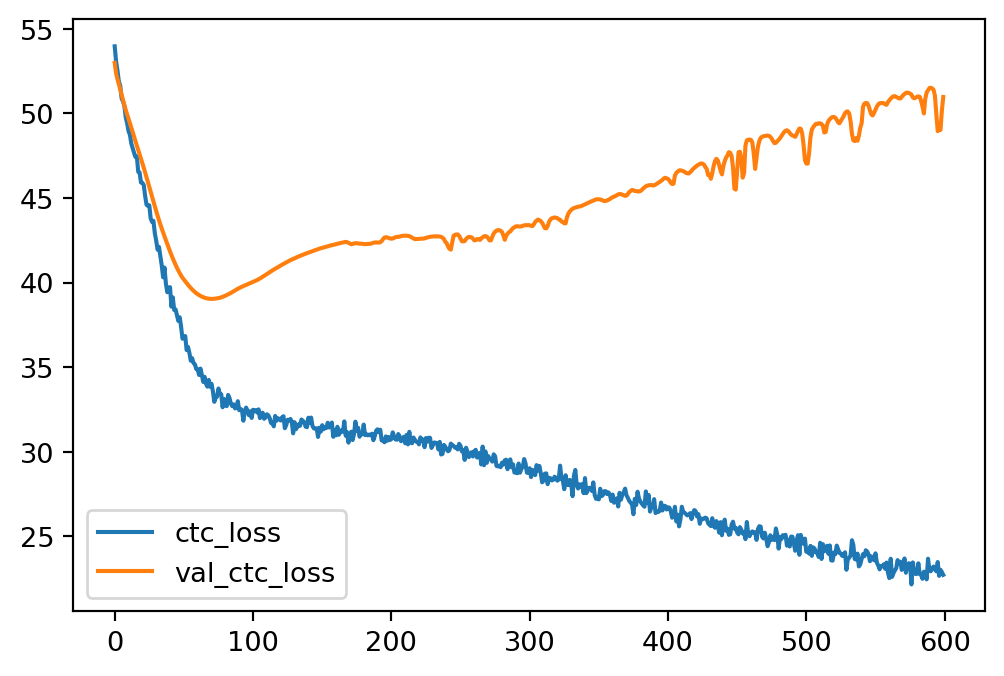

In [6]:
plt.clf();
plt.figure(dpi=196, figsize=(6,4))
plt.plot(H.history['ctc_loss'], '-', label='ctc_loss')
plt.plot(H.history['val_ctc_loss'], '-', label='val_ctc_loss')
plt.legend()

# Pytorch testing

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [8]:
class SegmentModel(nn.Module):
  def __init__(self, W, H, C, n_out):
    """
    This the basic model that is applied to each segment of the
    spectrogram. The input is assumed to have shape (W, H, C).
    Note: This model does not predict logits, instead has n_out 
    features softmaxed
    """
    super(SegmentModel, self).__init__()
    self.W = W
    self.H = H
    self.C = C
    self.n_out = n_out
    
    self.fc1 = nn.Linear(in_features=W*H*C, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=n_out)
    
  def forward(self, x):
    x = x.view(-1, self.W*self.H*self.C) # Flatten 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.dropout(x, 0.5)
    x = F.relu(self.fc3(x))
    return x

In [9]:
class FCBaseline(nn.Module):
  def __init__(self, W, H, C, num_classes):
    """
    This is the baseline model composed by a sequencewise fully connected 
    network followed by 2 layers of RNN networks. The input of this model is
    assumed to be of shape (batch_size, max(timesteps), W, H, C) padded with 
    zeros if needed
    """
    super(FCBaseline, self).__init__()
    self.W = W
    self.H = H
    self.C = C
    self.fc_size=128
    self.rnn_hidden = 16
    self.rnn_layers = 2
    self.segmentModel = SegmentModel(W, H, C, n_out=self.fc_size)
    self.rnn = nn.LSTM(input_size=self.fc_size,
                       hidden_size=self.rnn_hidden,
                       num_layers=self.rnn_layers,
                       batch_first=True)
    self.fc1 = nn.Linear(in_features=self.rnn_hidden, out_features=num_classes)
  
  # Thread here: https://discuss.pytorch.org/t/when-to-initialize-lstm-hidden-state/2323/5
  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    return Variable(weight.new(self.rnn_layers, batch_size, self.rnn_hidden).zero_())
  
  def forward(self, x):
    B, T = x.shape[0], x.shape[1]
    x = x.view(-1, self.W, self.H, self.C)
    x = self.segmentModel(x)
    x = x.view(B, T, -1)
    x, hidden = self.rnn(x)
    x = F.dropout(x, 0.25)
    x = self.fc1(x)
    return F.log_softmax(x)

In [10]:
def train(model, X_train, y_train, batch_size_train, X_val=None, y_val=None, batch_size_val=None, epochs=10):
  losses = []
  val_losses = []
  
  # create a stochastic gradient descent optimizer
  optimizer = optim.Adam(model.parameters())
  optimizer.zero_grad()
  
  # ctc loss
  ctc_loss = nn.CTCLoss()
  
  # Do we need validation?
  validate=False    
  if X_val != None or y_val != None or batch_size_val != None:
    if X_val == None or y_val == None or batch_size_val == None:
      raise ValueError("You must specify all three parameters: X_val, y_val, batch_size_val!")
    else:
      validate = True
      
  # Iterate over epochs
  for epoch in range(epochs):
    
    model.init_hidden(batch_size)
    
    if epoch % (epochs//10)==0:
      print("Epoch #{}".format(epoch))
      
    # Training loop
    for batch_idx in range(len(X_train)):
      
      data = torch.Tensor(X_train[batch_idx]).type(torch.float32).to('cuda')
      targets = torch.Tensor(y_train[batch_idx]).type(torch.int32).to('cuda')
      logits = model(data)
      
      slc = slice(batch_idx*batch_size_train, (batch_idx+1)*batch_size_train) 
      # CTCLoss expects logits to be of shape (timesteps, batch_size, num_classes)
      loss = ctc_loss(logits.transpose(0,1),
                      targets,
                      torch.Tensor(sequence_lengths[slc]).type(torch.int32).to('cpu'),
                      torch.Tensor(label_lengths[slc]).type(torch.int32).to('cpu'))
      
      loss.backward() # Calculates derivatives with autograd
      optimizer.step() # Update weights
      
      # Append loss
      losses.append(loss.detach().cpu().numpy())
  
    if validate == True:
      for batch_idx in range(len(X_val)):
        data_val = torch.Tensor(X_val[batch_idx]).type(torch.float32).to('cuda')
        targets_val = torch.Tensor(y_val[batch_idx]).type(torch.int32).to('cuda')
        logits_val = model(data_val)
        
        
        slc = slice(batch_idx*batch_size_val, (batch_idx+1)*batch_size_val) 
        # CTCLoss expects logits to be of shape (timesteps, batch_size, num_classes)
        val_loss = ctc_loss(logits_val.transpose(0,1),
                            targets_val,
                            torch.Tensor(sequence_lengths_val[slc]).type(torch.int32).to('cpu'),
                            torch.Tensor(label_lengths_val[slc]).type(torch.int32).to('cpu'))
        # Append val_loss
        val_losses.append(val_loss.detach().cpu().numpy())
  
  history = {'loss': losses, 'val_loss': val_losses}
  return history

In [11]:
baseline_model = FCBaseline(SEGMENT_WIDTH, SEGMENT_HEIGHT, SEGMENT_CHANNELS, num_classes)
history = train(baseline_model.to('cuda'),
                X_train=[X_batches[0]],
                y_train=[y_batches[0]],
                batch_size_train=batch_size,
                X_val=[X_batches_val[0]],
                y_val=[y_batches_val[0]],
                batch_size_val=batch_size_val,
                epochs=600)

Epoch #0


/home/dnagy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch #60
Epoch #120
Epoch #180
Epoch #240
Epoch #300
Epoch #360
Epoch #420
Epoch #480
Epoch #540


<Figure size 432x288 with 0 Axes>

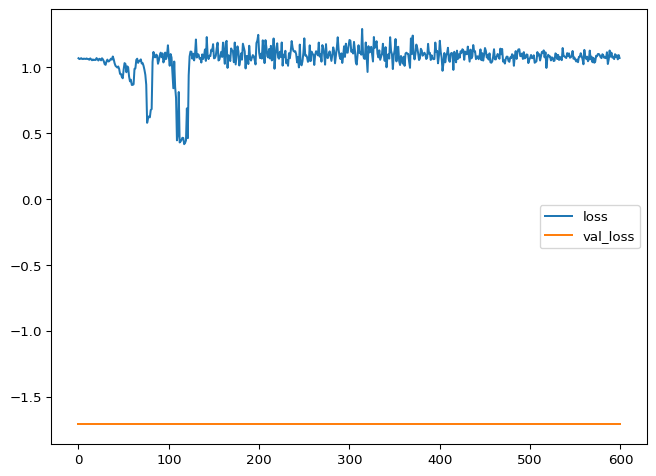

In [12]:
plt.clf();
plt.figure(figsize=(8,6), dpi=96)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()